In [1]:
import sys
sys.path.append('/content/file')

In [2]:
import torch
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from data import data
from model1 import *

# 新段落

# 新段落

In [3]:
# Check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Fetching Dataset
df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
df.addHorizontalFlipping()
#df.addVerticalFlipping()
df.addRandomCrop(size=32, padding=4)
#df.addAutoAugmentation()
#df.addHistogramEqualization()
df.addNormalizer()
#df.addGaussianNoise()
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Get Model
#model = ResNet(BasicBlock, 32, 4, [4, 4, 4, 2], 10, bias=True)
model = model1()
model = model.to(device)
print(summary(model, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,248
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,248
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,248
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,248
      BatchNorm2d-14           [-1, 32,

In [6]:
# Setting up training
EPOCHS=300
globalBestAccuracy = 0.0
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [7]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer) 
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.1
weightDecay = 0.0001
#optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learningRate, weight_decay=weightDecay)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential

In [8]:
# Training
for i in tqdm(range(EPOCHS)):
    for phase in ['train', 'test']:
        if phase == "train":
            loader = trainLoader
            model.train()
            optimizer.zero_grad()
        else:
            loader = testLoader
            model.eval()
        runningLoss = 0.0
        runningCorrects = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = lossFunction(output, labels)
            predicted_labels = torch.argmax(output, dim=1)
            #runningLoss += loss.item()*images.size(0)
            runningLoss += loss.item()
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))

  0%|          | 1/300 [00:37<3:08:37, 37.85s/it]

Training Loss : 1.7612893618774415, Testing Loss : 1.6802787078857422, Training Accuracy : 0.33832, Testing Accuracy : 0.3903


  1%|          | 2/300 [01:14<3:05:43, 37.40s/it]

Training Loss : 1.532690247192383, Testing Loss : 1.5012304344177245, Training Accuracy : 0.43192, Testing Accuracy : 0.452


  1%|          | 3/300 [01:52<3:05:54, 37.56s/it]

Training Loss : 1.396596163482666, Testing Loss : 1.3150763186454772, Training Accuracy : 0.4884, Testing Accuracy : 0.525


  1%|▏         | 4/300 [02:29<3:04:02, 37.31s/it]

Training Loss : 1.2220200114440918, Testing Loss : 1.1422368885040284, Training Accuracy : 0.55824, Testing Accuracy : 0.597


  2%|▏         | 5/300 [03:07<3:03:44, 37.37s/it]

Training Loss : 1.0681639511108398, Testing Loss : 1.0491390625953674, Training Accuracy : 0.61748, Testing Accuracy : 0.626


  2%|▏         | 6/300 [03:44<3:03:22, 37.42s/it]

Training Loss : 0.9525642306518555, Testing Loss : 0.9269574243545532, Training Accuracy : 0.65936, Testing Accuracy : 0.6747


  2%|▏         | 7/300 [04:22<3:02:50, 37.44s/it]

Training Loss : 0.8792877764892578, Testing Loss : 0.9302266786575317, Training Accuracy : 0.6888, Testing Accuracy : 0.6801


  3%|▎         | 8/300 [04:59<3:02:06, 37.42s/it]

Training Loss : 0.8009609765625, Testing Loss : 0.8703470077514649, Training Accuracy : 0.71864, Testing Accuracy : 0.701


  3%|▎         | 9/300 [05:36<3:01:35, 37.44s/it]

Training Loss : 0.7231483757019043, Testing Loss : 0.7903393814086914, Training Accuracy : 0.74764, Testing Accuracy : 0.7323


  3%|▎         | 10/300 [06:14<3:00:29, 37.34s/it]

Training Loss : 0.6825996541595459, Testing Loss : 0.7426103388786316, Training Accuracy : 0.76252, Testing Accuracy : 0.7547


  4%|▎         | 11/300 [06:51<2:59:39, 37.30s/it]

Training Loss : 0.6286059421539306, Testing Loss : 0.6628809020996094, Training Accuracy : 0.78116, Testing Accuracy : 0.7729


  4%|▍         | 12/300 [07:29<2:59:56, 37.49s/it]

Training Loss : 0.5893463283538818, Testing Loss : 0.7052746147155762, Training Accuracy : 0.79528, Testing Accuracy : 0.7612


  4%|▍         | 13/300 [08:06<2:59:06, 37.45s/it]

Training Loss : 0.5847791855621338, Testing Loss : 0.6584306235790253, Training Accuracy : 0.79768, Testing Accuracy : 0.7746


  5%|▍         | 14/300 [08:43<2:57:25, 37.22s/it]

Training Loss : 0.5402546646118164, Testing Loss : 0.6014700591087341, Training Accuracy : 0.81332, Testing Accuracy : 0.7899


  5%|▌         | 15/300 [09:20<2:57:02, 37.27s/it]

Training Loss : 0.5162297299194336, Testing Loss : 0.5763425876617432, Training Accuracy : 0.82108, Testing Accuracy : 0.8057


  5%|▌         | 16/300 [09:57<2:56:22, 37.26s/it]

Training Loss : 0.48333126304626467, Testing Loss : 0.5772347434043884, Training Accuracy : 0.8334, Testing Accuracy : 0.8033


  6%|▌         | 17/300 [10:34<2:54:55, 37.09s/it]

Training Loss : 0.46023086967468263, Testing Loss : 0.5297191067695618, Training Accuracy : 0.8389, Testing Accuracy : 0.8234


  6%|▌         | 18/300 [11:12<2:55:10, 37.27s/it]

Training Loss : 0.440582116394043, Testing Loss : 0.5591245555400849, Training Accuracy : 0.84746, Testing Accuracy : 0.8073


  6%|▋         | 19/300 [11:49<2:54:33, 37.27s/it]

Training Loss : 0.4364361617279053, Testing Loss : 0.5569011513710022, Training Accuracy : 0.84946, Testing Accuracy : 0.8156


  7%|▋         | 20/300 [12:26<2:53:11, 37.11s/it]

Training Loss : 0.42629062072753904, Testing Loss : 0.5136651504039764, Training Accuracy : 0.855, Testing Accuracy : 0.8241


  7%|▋         | 21/300 [13:03<2:53:00, 37.21s/it]

Training Loss : 0.4028879367828369, Testing Loss : 0.5103287125587463, Training Accuracy : 0.86158, Testing Accuracy : 0.8285


  7%|▋         | 22/300 [13:40<2:52:25, 37.21s/it]

Training Loss : 0.3945914643859863, Testing Loss : 0.5314128926753998, Training Accuracy : 0.86328, Testing Accuracy : 0.826


  8%|▊         | 23/300 [14:17<2:51:10, 37.08s/it]

Training Loss : 0.3830309310150147, Testing Loss : 0.5106112943172455, Training Accuracy : 0.86878, Testing Accuracy : 0.8265


  8%|▊         | 24/300 [14:54<2:50:44, 37.12s/it]

Training Loss : 0.3559916235733032, Testing Loss : 0.49428467173576357, Training Accuracy : 0.87576, Testing Accuracy : 0.8406


  8%|▊         | 25/300 [15:31<2:49:25, 36.96s/it]

Training Loss : 0.34842316860198974, Testing Loss : 0.49998394203186036, Training Accuracy : 0.88004, Testing Accuracy : 0.842


  9%|▊         | 26/300 [16:08<2:48:29, 36.89s/it]

Training Loss : 0.3293280946350098, Testing Loss : 0.47409241170883176, Training Accuracy : 0.8844, Testing Accuracy : 0.8483


  9%|▉         | 27/300 [16:44<2:47:34, 36.83s/it]

Training Loss : 0.3228035900497436, Testing Loss : 0.5196918929100036, Training Accuracy : 0.88854, Testing Accuracy : 0.834


  9%|▉         | 28/300 [17:21<2:46:35, 36.75s/it]

Training Loss : 0.32185747997283937, Testing Loss : 0.4964702125549316, Training Accuracy : 0.88772, Testing Accuracy : 0.8409


 10%|▉         | 29/300 [17:58<2:45:43, 36.69s/it]

Training Loss : 0.30904526180267333, Testing Loss : 0.4751679925441742, Training Accuracy : 0.89346, Testing Accuracy : 0.8446


 10%|█         | 30/300 [18:35<2:45:50, 36.85s/it]

Training Loss : 0.3027810448646545, Testing Loss : 0.4670262685775757, Training Accuracy : 0.89512, Testing Accuracy : 0.8505


 10%|█         | 31/300 [19:11<2:45:00, 36.81s/it]

Training Loss : 0.28700331624984743, Testing Loss : 0.4522630211830139, Training Accuracy : 0.89962, Testing Accuracy : 0.8564


 11%|█         | 32/300 [19:49<2:45:01, 36.95s/it]

Training Loss : 0.2808719085693359, Testing Loss : 0.45027902688980104, Training Accuracy : 0.90194, Testing Accuracy : 0.8571


 11%|█         | 33/300 [20:26<2:44:43, 37.02s/it]

Training Loss : 0.27325468740463255, Testing Loss : 0.45288556880950925, Training Accuracy : 0.90488, Testing Accuracy : 0.8554


 11%|█▏        | 34/300 [21:03<2:43:33, 36.89s/it]

Training Loss : 0.27132455310821535, Testing Loss : 0.43531847958564757, Training Accuracy : 0.90684, Testing Accuracy : 0.8598


 12%|█▏        | 35/300 [21:41<2:44:38, 37.28s/it]

Training Loss : 0.25579283819198606, Testing Loss : 0.43474373736381533, Training Accuracy : 0.91096, Testing Accuracy : 0.8673


 12%|█▏        | 36/300 [22:18<2:43:50, 37.24s/it]

Training Loss : 0.24861947710037233, Testing Loss : 0.45629068212509155, Training Accuracy : 0.91456, Testing Accuracy : 0.8593


 12%|█▏        | 37/300 [22:54<2:42:18, 37.03s/it]

Training Loss : 0.26047834505081174, Testing Loss : 0.4201096296310425, Training Accuracy : 0.90894, Testing Accuracy : 0.8657


 13%|█▎        | 38/300 [23:31<2:41:47, 37.05s/it]

Training Loss : 0.23990800380706787, Testing Loss : 0.4545416244029999, Training Accuracy : 0.91696, Testing Accuracy : 0.8687


 13%|█▎        | 39/300 [24:09<2:41:37, 37.15s/it]

Training Loss : 0.24003182456970215, Testing Loss : 0.4046580206394196, Training Accuracy : 0.91642, Testing Accuracy : 0.8705


 13%|█▎        | 40/300 [24:45<2:40:15, 36.98s/it]

Training Loss : 0.22293725721359253, Testing Loss : 0.43332036352157594, Training Accuracy : 0.92298, Testing Accuracy : 0.869


 14%|█▎        | 41/300 [25:23<2:40:25, 37.16s/it]

Training Loss : 0.21729387811660766, Testing Loss : 0.42377122168540954, Training Accuracy : 0.92518, Testing Accuracy : 0.8712


 14%|█▍        | 42/300 [26:00<2:39:47, 37.16s/it]

Training Loss : 0.20652641506195069, Testing Loss : 0.45844642906188965, Training Accuracy : 0.92748, Testing Accuracy : 0.8678


 14%|█▍        | 43/300 [26:37<2:38:26, 36.99s/it]

Training Loss : 0.21041228649139404, Testing Loss : 0.44674423656463624, Training Accuracy : 0.92712, Testing Accuracy : 0.8617


 15%|█▍        | 44/300 [27:14<2:38:03, 37.05s/it]

Training Loss : 0.2084976113128662, Testing Loss : 0.44562106726169587, Training Accuracy : 0.92826, Testing Accuracy : 0.871


 15%|█▌        | 45/300 [27:51<2:37:40, 37.10s/it]

Training Loss : 0.1985959127140045, Testing Loss : 0.43761129322052, Training Accuracy : 0.93112, Testing Accuracy : 0.869


 15%|█▌        | 46/300 [28:29<2:37:34, 37.22s/it]

Training Loss : 0.192173259267807, Testing Loss : 0.4437014150619507, Training Accuracy : 0.93306, Testing Accuracy : 0.8697


 16%|█▌        | 47/300 [29:06<2:36:49, 37.19s/it]

Training Loss : 0.19443419942855836, Testing Loss : 0.4261657877445221, Training Accuracy : 0.93192, Testing Accuracy : 0.8739


 16%|█▌        | 48/300 [29:43<2:36:26, 37.25s/it]

Training Loss : 0.19349790610313417, Testing Loss : 0.42034925775527954, Training Accuracy : 0.93172, Testing Accuracy : 0.8778


 16%|█▋        | 49/300 [30:20<2:35:29, 37.17s/it]

Training Loss : 0.18334222505569459, Testing Loss : 0.45618979024887085, Training Accuracy : 0.9353, Testing Accuracy : 0.8712


 17%|█▋        | 50/300 [30:57<2:34:12, 37.01s/it]

Training Loss : 0.1760231380558014, Testing Loss : 0.46158050932884215, Training Accuracy : 0.9378, Testing Accuracy : 0.8721


 17%|█▋        | 51/300 [31:34<2:33:49, 37.07s/it]

Training Loss : 0.17232190679550172, Testing Loss : 0.453213320016861, Training Accuracy : 0.93994, Testing Accuracy : 0.875


 17%|█▋        | 52/300 [32:11<2:33:26, 37.12s/it]

Training Loss : 0.16962588335990905, Testing Loss : 0.46857249035835263, Training Accuracy : 0.9418, Testing Accuracy : 0.8727


 18%|█▊        | 53/300 [32:48<2:32:41, 37.09s/it]

Training Loss : 0.17246746139526367, Testing Loss : 0.46880813217163086, Training Accuracy : 0.94032, Testing Accuracy : 0.8686


 18%|█▊        | 54/300 [33:25<2:32:01, 37.08s/it]

Training Loss : 0.1678241845703125, Testing Loss : 0.4733421762943268, Training Accuracy : 0.94204, Testing Accuracy : 0.8777


 18%|█▊        | 55/300 [34:03<2:31:34, 37.12s/it]

Training Loss : 0.16504434579849242, Testing Loss : 0.416986474609375, Training Accuracy : 0.9426, Testing Accuracy : 0.8817


 19%|█▊        | 56/300 [34:39<2:30:21, 36.97s/it]

Training Loss : 0.15683004914283752, Testing Loss : 0.4180727252006531, Training Accuracy : 0.94456, Testing Accuracy : 0.8868


 19%|█▉        | 57/300 [35:16<2:29:52, 37.01s/it]

Training Loss : 0.1539602238559723, Testing Loss : 0.44372039794921875, Training Accuracy : 0.94664, Testing Accuracy : 0.8825


 19%|█▉        | 58/300 [35:53<2:29:29, 37.06s/it]

Training Loss : 0.14601773118972777, Testing Loss : 0.4307588605880737, Training Accuracy : 0.94888, Testing Accuracy : 0.884


 20%|█▉        | 59/300 [36:31<2:28:52, 37.06s/it]

Training Loss : 0.13368543144226075, Testing Loss : 0.4670615098953247, Training Accuracy : 0.9537, Testing Accuracy : 0.882


 20%|██        | 60/300 [37:08<2:28:23, 37.10s/it]

Training Loss : 0.13561011110305787, Testing Loss : 0.42477316551208494, Training Accuracy : 0.95286, Testing Accuracy : 0.8899


 20%|██        | 61/300 [37:45<2:27:49, 37.11s/it]

Training Loss : 0.13738606874465942, Testing Loss : 0.4419823296546936, Training Accuracy : 0.9518, Testing Accuracy : 0.8891


 21%|██        | 62/300 [38:21<2:26:37, 36.96s/it]

Training Loss : 0.13590645483970643, Testing Loss : 0.42217003984451296, Training Accuracy : 0.95276, Testing Accuracy : 0.8866


 21%|██        | 63/300 [38:59<2:26:19, 37.04s/it]

Training Loss : 0.13128558267116547, Testing Loss : 0.4303488006591797, Training Accuracy : 0.95522, Testing Accuracy : 0.888


 21%|██▏       | 64/300 [39:36<2:25:50, 37.08s/it]

Training Loss : 0.1317881777858734, Testing Loss : 0.4527588927268982, Training Accuracy : 0.95376, Testing Accuracy : 0.881


 22%|██▏       | 65/300 [40:13<2:25:34, 37.17s/it]

Training Loss : 0.12376098157405853, Testing Loss : 0.4557065956115723, Training Accuracy : 0.95734, Testing Accuracy : 0.8879


 22%|██▏       | 66/300 [40:50<2:25:01, 37.19s/it]

Training Loss : 0.12239465036869049, Testing Loss : 0.45597680168151855, Training Accuracy : 0.95596, Testing Accuracy : 0.8896


 22%|██▏       | 67/300 [41:28<2:24:36, 37.24s/it]

Training Loss : 0.11688228309154511, Testing Loss : 0.4860461766242981, Training Accuracy : 0.95848, Testing Accuracy : 0.8878


 23%|██▎       | 68/300 [42:05<2:23:29, 37.11s/it]

Training Loss : 0.12084462242603301, Testing Loss : 0.4348702650547028, Training Accuracy : 0.95832, Testing Accuracy : 0.8878


 23%|██▎       | 69/300 [42:42<2:23:11, 37.19s/it]

Training Loss : 0.1120481704568863, Testing Loss : 0.4445632109165192, Training Accuracy : 0.96072, Testing Accuracy : 0.8938


 23%|██▎       | 70/300 [43:19<2:22:35, 37.20s/it]

Training Loss : 0.10471297618627548, Testing Loss : 0.4714765480041504, Training Accuracy : 0.96352, Testing Accuracy : 0.8899


 24%|██▎       | 71/300 [43:57<2:22:11, 37.26s/it]

Training Loss : 0.10872180584430695, Testing Loss : 0.44044160335063937, Training Accuracy : 0.96268, Testing Accuracy : 0.892


 24%|██▍       | 72/300 [44:34<2:21:43, 37.30s/it]

Training Loss : 0.11224436859607696, Testing Loss : 0.45136872692108154, Training Accuracy : 0.9602, Testing Accuracy : 0.8929


 24%|██▍       | 73/300 [45:11<2:21:06, 37.30s/it]

Training Loss : 0.10305990847110748, Testing Loss : 0.47785255677700045, Training Accuracy : 0.96312, Testing Accuracy : 0.8914


 25%|██▍       | 74/300 [45:48<2:19:58, 37.16s/it]

Training Loss : 0.11257998888492585, Testing Loss : 0.4732910079956055, Training Accuracy : 0.96074, Testing Accuracy : 0.8883


 25%|██▌       | 75/300 [46:26<2:19:37, 37.23s/it]

Training Loss : 0.09954543870449066, Testing Loss : 0.4944575076341629, Training Accuracy : 0.96592, Testing Accuracy : 0.8952


 25%|██▌       | 76/300 [47:03<2:19:13, 37.29s/it]

Training Loss : 0.09749398547172547, Testing Loss : 0.44840428915023806, Training Accuracy : 0.96612, Testing Accuracy : 0.8924


 26%|██▌       | 77/300 [47:40<2:18:45, 37.33s/it]

Training Loss : 0.09961942471027374, Testing Loss : 0.4852031666755676, Training Accuracy : 0.96626, Testing Accuracy : 0.8923


 26%|██▌       | 78/300 [48:18<2:18:17, 37.38s/it]

Training Loss : 0.10159897282838821, Testing Loss : 0.47720212769508363, Training Accuracy : 0.96516, Testing Accuracy : 0.8895


 26%|██▋       | 79/300 [48:55<2:17:40, 37.38s/it]

Training Loss : 0.0948669535446167, Testing Loss : 0.46818587446212767, Training Accuracy : 0.96748, Testing Accuracy : 0.8951


 27%|██▋       | 80/300 [49:32<2:16:20, 37.18s/it]

Training Loss : 0.09080136573791504, Testing Loss : 0.4620028203964233, Training Accuracy : 0.96798, Testing Accuracy : 0.892


 27%|██▋       | 81/300 [50:10<2:16:05, 37.28s/it]

Training Loss : 0.08305693566560746, Testing Loss : 0.4690918561935425, Training Accuracy : 0.97068, Testing Accuracy : 0.8969


 27%|██▋       | 82/300 [50:47<2:15:40, 37.34s/it]

Training Loss : 0.08918884890317917, Testing Loss : 0.44108325958251954, Training Accuracy : 0.9695, Testing Accuracy : 0.8916


 28%|██▊       | 83/300 [51:24<2:14:57, 37.32s/it]

Training Loss : 0.08750455404281617, Testing Loss : 0.5187185843467712, Training Accuracy : 0.97046, Testing Accuracy : 0.8931


 28%|██▊       | 84/300 [52:02<2:14:21, 37.32s/it]

Training Loss : 0.09735135721921921, Testing Loss : 0.4413216486930847, Training Accuracy : 0.96678, Testing Accuracy : 0.8872


 28%|██▊       | 85/300 [52:39<2:13:46, 37.33s/it]

Training Loss : 0.08916981819152832, Testing Loss : 0.5043721038341522, Training Accuracy : 0.96946, Testing Accuracy : 0.8942


 29%|██▊       | 86/300 [53:16<2:12:31, 37.16s/it]

Training Loss : 0.09144215532541275, Testing Loss : 0.434272180557251, Training Accuracy : 0.96794, Testing Accuracy : 0.8907


 29%|██▉       | 87/300 [53:53<2:11:54, 37.15s/it]

Training Loss : 0.08552518316745758, Testing Loss : 0.5259964469909668, Training Accuracy : 0.97054, Testing Accuracy : 0.8925


 29%|██▉       | 88/300 [54:30<2:11:08, 37.11s/it]

Training Loss : 0.08417635909438133, Testing Loss : 0.45480215940475466, Training Accuracy : 0.97054, Testing Accuracy : 0.8923


 30%|██▉       | 89/300 [55:07<2:10:23, 37.08s/it]

Training Loss : 0.0891002353668213, Testing Loss : 0.446326762008667, Training Accuracy : 0.96974, Testing Accuracy : 0.8928


 30%|███       | 90/300 [55:44<2:09:43, 37.06s/it]

Training Loss : 0.07333003261566162, Testing Loss : 0.5075609869003296, Training Accuracy : 0.97472, Testing Accuracy : 0.8916


 30%|███       | 91/300 [56:21<2:09:14, 37.10s/it]

Training Loss : 0.07926122561454772, Testing Loss : 0.45798582820892336, Training Accuracy : 0.97258, Testing Accuracy : 0.8969


 31%|███       | 92/300 [56:58<2:08:11, 36.98s/it]

Training Loss : 0.07227207886457443, Testing Loss : 0.4850716288089752, Training Accuracy : 0.9754, Testing Accuracy : 0.8993


 31%|███       | 93/300 [57:35<2:07:39, 37.00s/it]

Training Loss : 0.07419922425031662, Testing Loss : 0.4791509219169617, Training Accuracy : 0.97398, Testing Accuracy : 0.8953


 31%|███▏      | 94/300 [58:12<2:07:10, 37.04s/it]

Training Loss : 0.07269077630758286, Testing Loss : 0.47035479650497436, Training Accuracy : 0.97446, Testing Accuracy : 0.9032


 32%|███▏      | 95/300 [58:49<2:06:34, 37.05s/it]

Training Loss : 0.07383380784988404, Testing Loss : 0.46746600432395935, Training Accuracy : 0.9744, Testing Accuracy : 0.8976


 32%|███▏      | 96/300 [59:26<2:05:54, 37.03s/it]

Training Loss : 0.06619160495519638, Testing Loss : 0.49529675334692, Training Accuracy : 0.97758, Testing Accuracy : 0.9009


 32%|███▏      | 97/300 [1:00:03<2:05:17, 37.03s/it]

Training Loss : 0.07036207566022873, Testing Loss : 0.4710968243598938, Training Accuracy : 0.97498, Testing Accuracy : 0.8938


 33%|███▎      | 98/300 [1:00:40<2:04:14, 36.90s/it]

Training Loss : 0.06995511933803558, Testing Loss : 0.4978171365737915, Training Accuracy : 0.97622, Testing Accuracy : 0.8974


 33%|███▎      | 99/300 [1:01:17<2:03:41, 36.92s/it]

Training Loss : 0.0651953007465601, Testing Loss : 0.4686303466796875, Training Accuracy : 0.97766, Testing Accuracy : 0.9001


 33%|███▎      | 100/300 [1:01:54<2:03:13, 36.97s/it]

Training Loss : 0.06274360044538975, Testing Loss : 0.5289840842485428, Training Accuracy : 0.9785, Testing Accuracy : 0.8953


 34%|███▎      | 101/300 [1:02:31<2:02:34, 36.96s/it]

Training Loss : 0.0677878751718998, Testing Loss : 0.4702394725799561, Training Accuracy : 0.97562, Testing Accuracy : 0.9004


 34%|███▍      | 102/300 [1:03:08<2:01:58, 36.96s/it]

Training Loss : 0.05973094333052635, Testing Loss : 0.5229109079360962, Training Accuracy : 0.97938, Testing Accuracy : 0.8979


 34%|███▍      | 103/300 [1:03:45<2:01:28, 37.00s/it]

Training Loss : 0.05914264229774475, Testing Loss : 0.49184523897171023, Training Accuracy : 0.97966, Testing Accuracy : 0.8976


 35%|███▍      | 104/300 [1:04:21<2:00:30, 36.89s/it]

Training Loss : 0.06152354933381081, Testing Loss : 0.47595557146072387, Training Accuracy : 0.97892, Testing Accuracy : 0.904


 35%|███▌      | 105/300 [1:04:58<2:00:01, 36.93s/it]

Training Loss : 0.05560547929763794, Testing Loss : 0.5150763715744019, Training Accuracy : 0.98104, Testing Accuracy : 0.9004


 35%|███▌      | 106/300 [1:05:35<1:59:31, 36.96s/it]

Training Loss : 0.05985050510287285, Testing Loss : 0.4846044027328491, Training Accuracy : 0.97994, Testing Accuracy : 0.8991


 36%|███▌      | 107/300 [1:06:12<1:58:57, 36.98s/it]

Training Loss : 0.059118653255701065, Testing Loss : 0.5261524899721146, Training Accuracy : 0.97994, Testing Accuracy : 0.9013


 36%|███▌      | 108/300 [1:06:49<1:58:24, 37.00s/it]

Training Loss : 0.057756634471416476, Testing Loss : 0.46165368556976316, Training Accuracy : 0.98022, Testing Accuracy : 0.9024


 36%|███▋      | 109/300 [1:07:26<1:57:23, 36.88s/it]

Training Loss : 0.055051952265501025, Testing Loss : 0.48083714179992676, Training Accuracy : 0.98118, Testing Accuracy : 0.9036


 37%|███▋      | 110/300 [1:08:03<1:56:51, 36.90s/it]

Training Loss : 0.059057847702503205, Testing Loss : 0.5051037941932678, Training Accuracy : 0.97918, Testing Accuracy : 0.901


 37%|███▋      | 111/300 [1:08:40<1:56:27, 36.97s/it]

Training Loss : 0.05660958906769752, Testing Loss : 0.5065583106040955, Training Accuracy : 0.98004, Testing Accuracy : 0.9058


 37%|███▋      | 112/300 [1:09:17<1:55:32, 36.87s/it]

Training Loss : 0.0535504735994339, Testing Loss : 0.5389558032989502, Training Accuracy : 0.98142, Testing Accuracy : 0.8941


 38%|███▊      | 113/300 [1:09:54<1:55:26, 37.04s/it]

Training Loss : 0.05847219200372696, Testing Loss : 0.4858100603103638, Training Accuracy : 0.98068, Testing Accuracy : 0.9041


 38%|███▊      | 114/300 [1:10:31<1:54:47, 37.03s/it]

Training Loss : 0.048890701599121095, Testing Loss : 0.5162480721950531, Training Accuracy : 0.9833, Testing Accuracy : 0.901


 38%|███▊      | 115/300 [1:11:08<1:53:46, 36.90s/it]

Training Loss : 0.04659530795633793, Testing Loss : 0.5423445433616638, Training Accuracy : 0.98372, Testing Accuracy : 0.9029


 39%|███▊      | 116/300 [1:11:45<1:53:14, 36.93s/it]

Training Loss : 0.05568324844539165, Testing Loss : 0.51307631483078, Training Accuracy : 0.98108, Testing Accuracy : 0.8958


 39%|███▉      | 117/300 [1:12:22<1:52:39, 36.94s/it]

Training Loss : 0.05749989790022373, Testing Loss : 0.5255763090133667, Training Accuracy : 0.9808, Testing Accuracy : 0.9018


 39%|███▉      | 118/300 [1:12:58<1:51:45, 36.84s/it]

Training Loss : 0.04917497867405415, Testing Loss : 0.5267138474464417, Training Accuracy : 0.9824, Testing Accuracy : 0.898


 40%|███▉      | 119/300 [1:13:36<1:51:35, 36.99s/it]

Training Loss : 0.04799441917717457, Testing Loss : 0.5258032548904419, Training Accuracy : 0.98406, Testing Accuracy : 0.9019


 40%|████      | 120/300 [1:14:13<1:51:00, 37.00s/it]

Training Loss : 0.04463751640409231, Testing Loss : 0.5158607528686523, Training Accuracy : 0.98432, Testing Accuracy : 0.9018


 40%|████      | 121/300 [1:14:49<1:50:01, 36.88s/it]

Training Loss : 0.046896234742999074, Testing Loss : 0.46713067598342894, Training Accuracy : 0.98406, Testing Accuracy : 0.9042


 41%|████      | 122/300 [1:15:26<1:49:32, 36.92s/it]

Training Loss : 0.0404829135376215, Testing Loss : 0.5373259443283082, Training Accuracy : 0.9859, Testing Accuracy : 0.9037


 41%|████      | 123/300 [1:16:03<1:49:03, 36.97s/it]

Training Loss : 0.04961883239328861, Testing Loss : 0.5320064673900604, Training Accuracy : 0.983, Testing Accuracy : 0.8995


 41%|████▏     | 124/300 [1:16:40<1:48:14, 36.90s/it]

Training Loss : 0.043327516114711764, Testing Loss : 0.5117832458496093, Training Accuracy : 0.9853, Testing Accuracy : 0.9085


 42%|████▏     | 125/300 [1:17:18<1:48:00, 37.03s/it]

Training Loss : 0.042865624703019856, Testing Loss : 0.5302955457687378, Training Accuracy : 0.98538, Testing Accuracy : 0.9004


 42%|████▏     | 126/300 [1:17:55<1:47:26, 37.05s/it]

Training Loss : 0.043873305710554124, Testing Loss : 0.5408802297592163, Training Accuracy : 0.98482, Testing Accuracy : 0.9055


 42%|████▏     | 127/300 [1:18:31<1:46:24, 36.90s/it]

Training Loss : 0.050110109390616414, Testing Loss : 0.5339096759796143, Training Accuracy : 0.98302, Testing Accuracy : 0.8993


 43%|████▎     | 128/300 [1:19:08<1:45:46, 36.90s/it]

Training Loss : 0.052475960943698885, Testing Loss : 0.529653082370758, Training Accuracy : 0.98126, Testing Accuracy : 0.8961


 43%|████▎     | 129/300 [1:19:45<1:45:18, 36.95s/it]

Training Loss : 0.04738542608082295, Testing Loss : 0.5399084976196289, Training Accuracy : 0.98414, Testing Accuracy : 0.9027


 43%|████▎     | 130/300 [1:20:22<1:44:54, 37.03s/it]

Training Loss : 0.0425244503223896, Testing Loss : 0.49561109981536866, Training Accuracy : 0.98496, Testing Accuracy : 0.9065


 44%|████▎     | 131/300 [1:20:59<1:44:12, 37.00s/it]

Training Loss : 0.035373840218186375, Testing Loss : 0.5604501363754273, Training Accuracy : 0.98806, Testing Accuracy : 0.9038


 44%|████▍     | 132/300 [1:21:36<1:43:37, 37.01s/it]

Training Loss : 0.04242708231210709, Testing Loss : 0.4931299789428711, Training Accuracy : 0.98612, Testing Accuracy : 0.9059


 44%|████▍     | 133/300 [1:22:13<1:42:37, 36.87s/it]

Training Loss : 0.03856290811806917, Testing Loss : 0.5432182745933533, Training Accuracy : 0.9868, Testing Accuracy : 0.9069


 45%|████▍     | 134/300 [1:22:50<1:42:07, 36.91s/it]

Training Loss : 0.03625028071701527, Testing Loss : 0.5287566530227661, Training Accuracy : 0.98784, Testing Accuracy : 0.9099


 45%|████▌     | 135/300 [1:23:27<1:41:35, 36.94s/it]

Training Loss : 0.033175580273270604, Testing Loss : 0.5993577648162842, Training Accuracy : 0.98858, Testing Accuracy : 0.9037


 45%|████▌     | 136/300 [1:24:04<1:41:00, 36.95s/it]

Training Loss : 0.03868340116500855, Testing Loss : 0.5965326555252075, Training Accuracy : 0.9867, Testing Accuracy : 0.8977


 46%|████▌     | 137/300 [1:24:41<1:40:27, 36.98s/it]

Training Loss : 0.040027396027743814, Testing Loss : 0.6423825011253357, Training Accuracy : 0.9863, Testing Accuracy : 0.8974


 46%|████▌     | 138/300 [1:25:18<1:39:51, 36.98s/it]

Training Loss : 0.04707294954925775, Testing Loss : 0.5717375568389893, Training Accuracy : 0.98492, Testing Accuracy : 0.8951


 46%|████▋     | 139/300 [1:25:55<1:38:57, 36.88s/it]

Training Loss : 0.042675723351836205, Testing Loss : 0.5652285215377808, Training Accuracy : 0.98578, Testing Accuracy : 0.9075


 47%|████▋     | 140/300 [1:26:32<1:38:25, 36.91s/it]

Training Loss : 0.03651668703556061, Testing Loss : 0.5188943723678588, Training Accuracy : 0.9876, Testing Accuracy : 0.9034


 47%|████▋     | 141/300 [1:27:08<1:37:51, 36.93s/it]

Training Loss : 0.032265024144351485, Testing Loss : 0.5268880931854248, Training Accuracy : 0.98894, Testing Accuracy : 0.9118


 47%|████▋     | 142/300 [1:27:45<1:37:11, 36.91s/it]

Training Loss : 0.030385530621409418, Testing Loss : 0.5339894323348999, Training Accuracy : 0.98928, Testing Accuracy : 0.9094


 48%|████▊     | 143/300 [1:28:22<1:36:37, 36.93s/it]

Training Loss : 0.03174704982727766, Testing Loss : 0.5126209613800049, Training Accuracy : 0.98874, Testing Accuracy : 0.9098


 48%|████▊     | 144/300 [1:28:59<1:36:05, 36.96s/it]

Training Loss : 0.02848258044600487, Testing Loss : 0.5863223530769348, Training Accuracy : 0.99032, Testing Accuracy : 0.9063


 48%|████▊     | 145/300 [1:29:36<1:35:09, 36.84s/it]

Training Loss : 0.03130759392350912, Testing Loss : 0.5465357965469361, Training Accuracy : 0.98912, Testing Accuracy : 0.9074


 49%|████▊     | 146/300 [1:30:13<1:34:44, 36.91s/it]

Training Loss : 0.030212885541953147, Testing Loss : 0.5666562673568726, Training Accuracy : 0.98988, Testing Accuracy : 0.9085


 49%|████▉     | 147/300 [1:30:50<1:34:10, 36.93s/it]

Training Loss : 0.027775082965791224, Testing Loss : 0.5674400506019592, Training Accuracy : 0.99048, Testing Accuracy : 0.9058


 49%|████▉     | 148/300 [1:31:27<1:33:41, 36.98s/it]

Training Loss : 0.03061933452785015, Testing Loss : 0.5282243508338929, Training Accuracy : 0.98986, Testing Accuracy : 0.9131


 50%|████▉     | 149/300 [1:32:04<1:33:07, 37.00s/it]

Training Loss : 0.027617779856324194, Testing Loss : 0.5478659187316894, Training Accuracy : 0.99068, Testing Accuracy : 0.9109


 50%|█████     | 150/300 [1:32:41<1:32:33, 37.02s/it]

Training Loss : 0.027489297343939543, Testing Loss : 0.5436308884620666, Training Accuracy : 0.9906, Testing Accuracy : 0.9081


 50%|█████     | 151/300 [1:33:18<1:31:37, 36.89s/it]

Training Loss : 0.026710032808184625, Testing Loss : 0.5364008938789367, Training Accuracy : 0.99144, Testing Accuracy : 0.9109


 51%|█████     | 152/300 [1:33:55<1:31:05, 36.93s/it]

Training Loss : 0.02710284973025322, Testing Loss : 0.5511161105155945, Training Accuracy : 0.9908, Testing Accuracy : 0.9093


 51%|█████     | 153/300 [1:34:32<1:30:44, 37.04s/it]

Training Loss : 0.02636870953127742, Testing Loss : 0.5556598452568055, Training Accuracy : 0.99108, Testing Accuracy : 0.9115


 51%|█████▏    | 154/300 [1:35:09<1:29:54, 36.95s/it]

Training Loss : 0.02205266455538571, Testing Loss : 0.5063443903923035, Training Accuracy : 0.99218, Testing Accuracy : 0.9132


 52%|█████▏    | 155/300 [1:35:46<1:29:34, 37.07s/it]

Training Loss : 0.02124142979733646, Testing Loss : 0.5575721256256103, Training Accuracy : 0.99244, Testing Accuracy : 0.9112


 52%|█████▏    | 156/300 [1:36:23<1:28:49, 37.01s/it]

Training Loss : 0.02342769945666194, Testing Loss : 0.5023820671081543, Training Accuracy : 0.99178, Testing Accuracy : 0.9134


 52%|█████▏    | 157/300 [1:37:00<1:28:04, 36.95s/it]

Training Loss : 0.028372303819805385, Testing Loss : 0.5748921613693238, Training Accuracy : 0.98994, Testing Accuracy : 0.9079


 53%|█████▎    | 158/300 [1:37:37<1:27:31, 36.98s/it]

Training Loss : 0.02612676921747625, Testing Loss : 0.5331746522903442, Training Accuracy : 0.9911, Testing Accuracy : 0.9137


 53%|█████▎    | 159/300 [1:38:14<1:26:39, 36.88s/it]

Training Loss : 0.026850178295262157, Testing Loss : 0.5390435252666473, Training Accuracy : 0.99128, Testing Accuracy : 0.9104


 53%|█████▎    | 160/300 [1:38:51<1:26:10, 36.93s/it]

Training Loss : 0.021842014281749724, Testing Loss : 0.5333225664138794, Training Accuracy : 0.9926, Testing Accuracy : 0.9139


 54%|█████▎    | 161/300 [1:39:28<1:25:49, 37.04s/it]

Training Loss : 0.01902790687985718, Testing Loss : 0.5786014082431793, Training Accuracy : 0.99382, Testing Accuracy : 0.9126


 54%|█████▍    | 162/300 [1:40:04<1:24:48, 36.87s/it]

Training Loss : 0.022078139334619044, Testing Loss : 0.5308930640697479, Training Accuracy : 0.9925, Testing Accuracy : 0.9114


 54%|█████▍    | 163/300 [1:40:41<1:24:14, 36.90s/it]

Training Loss : 0.019771602395623922, Testing Loss : 0.5404877131462097, Training Accuracy : 0.99358, Testing Accuracy : 0.9151


 55%|█████▍    | 164/300 [1:41:18<1:23:34, 36.87s/it]

Training Loss : 0.0175989075775072, Testing Loss : 0.6118018685340881, Training Accuracy : 0.99394, Testing Accuracy : 0.9096


 55%|█████▌    | 165/300 [1:41:55<1:22:59, 36.88s/it]

Training Loss : 0.02153796723742038, Testing Loss : 0.5818472640991211, Training Accuracy : 0.99278, Testing Accuracy : 0.9096


 55%|█████▌    | 166/300 [1:42:32<1:22:23, 36.89s/it]

Training Loss : 0.019773089875467123, Testing Loss : 0.5934883389472961, Training Accuracy : 0.9937, Testing Accuracy : 0.9104


 56%|█████▌    | 167/300 [1:43:09<1:21:49, 36.92s/it]

Training Loss : 0.019821482483036817, Testing Loss : 0.5378770969390869, Training Accuracy : 0.99356, Testing Accuracy : 0.9128


 56%|█████▌    | 168/300 [1:43:46<1:21:16, 36.94s/it]

Training Loss : 0.01778298244746402, Testing Loss : 0.5594097292900085, Training Accuracy : 0.99372, Testing Accuracy : 0.918


 56%|█████▋    | 169/300 [1:44:23<1:20:44, 36.98s/it]

Training Loss : 0.01721019159378484, Testing Loss : 0.5666455045700073, Training Accuracy : 0.99476, Testing Accuracy : 0.9126


 57%|█████▋    | 170/300 [1:45:00<1:19:50, 36.85s/it]

Training Loss : 0.019386199228866027, Testing Loss : 0.5450939203262329, Training Accuracy : 0.99406, Testing Accuracy : 0.9148


 57%|█████▋    | 171/300 [1:45:36<1:19:14, 36.85s/it]

Training Loss : 0.017378922868929805, Testing Loss : 0.5660208981752396, Training Accuracy : 0.99396, Testing Accuracy : 0.9119


 57%|█████▋    | 172/300 [1:46:13<1:18:45, 36.92s/it]

Training Loss : 0.022907371966131032, Testing Loss : 0.553626953458786, Training Accuracy : 0.99254, Testing Accuracy : 0.9133


 58%|█████▊    | 173/300 [1:46:50<1:18:09, 36.92s/it]

Training Loss : 0.01727527840077877, Testing Loss : 0.5594776899337769, Training Accuracy : 0.9942, Testing Accuracy : 0.9163


 58%|█████▊    | 174/300 [1:47:27<1:17:36, 36.96s/it]

Training Loss : 0.017218107607476413, Testing Loss : 0.5862092778205872, Training Accuracy : 0.99408, Testing Accuracy : 0.9149


 58%|█████▊    | 175/300 [1:48:04<1:17:00, 36.97s/it]

Training Loss : 0.014370913967043162, Testing Loss : 0.5648525968551635, Training Accuracy : 0.9952, Testing Accuracy : 0.916


 59%|█████▊    | 176/300 [1:48:41<1:16:07, 36.84s/it]

Training Loss : 0.01665367902968079, Testing Loss : 0.5796378164291381, Training Accuracy : 0.9944, Testing Accuracy : 0.9138


 59%|█████▉    | 177/300 [1:49:18<1:15:31, 36.84s/it]

Training Loss : 0.014096215781234205, Testing Loss : 0.6459223359584808, Training Accuracy : 0.99538, Testing Accuracy : 0.9101


 59%|█████▉    | 178/300 [1:49:55<1:15:12, 36.99s/it]

Training Loss : 0.0177809327916801, Testing Loss : 0.6043486547470093, Training Accuracy : 0.99386, Testing Accuracy : 0.9125


 60%|█████▉    | 179/300 [1:50:32<1:14:32, 36.97s/it]

Training Loss : 0.017864534032978118, Testing Loss : 0.6242278861999512, Training Accuracy : 0.99388, Testing Accuracy : 0.9125


 60%|██████    | 180/300 [1:51:09<1:13:53, 36.94s/it]

Training Loss : 0.01590390984650701, Testing Loss : 0.5877638772964477, Training Accuracy : 0.99478, Testing Accuracy : 0.9137


 60%|██████    | 181/300 [1:51:46<1:13:06, 36.86s/it]

Training Loss : 0.013651412466131151, Testing Loss : 0.5937345624923706, Training Accuracy : 0.99526, Testing Accuracy : 0.9119


 61%|██████    | 182/300 [1:52:23<1:12:30, 36.87s/it]

Training Loss : 0.013442861049845815, Testing Loss : 0.6283399932861328, Training Accuracy : 0.99528, Testing Accuracy : 0.9121


 61%|██████    | 183/300 [1:53:00<1:11:58, 36.91s/it]

Training Loss : 0.01941821800015867, Testing Loss : 0.6378789882659912, Training Accuracy : 0.99358, Testing Accuracy : 0.91


 61%|██████▏   | 184/300 [1:53:36<1:11:11, 36.82s/it]

Training Loss : 0.022689115394949912, Testing Loss : 0.5904353265762329, Training Accuracy : 0.99278, Testing Accuracy : 0.9111


 62%|██████▏   | 185/300 [1:54:14<1:10:58, 37.03s/it]

Training Loss : 0.017278674443084747, Testing Loss : 0.5591000919342041, Training Accuracy : 0.99438, Testing Accuracy : 0.9179


 62%|██████▏   | 186/300 [1:54:51<1:10:24, 37.05s/it]

Training Loss : 0.015256193819791078, Testing Loss : 0.5405318408966064, Training Accuracy : 0.99482, Testing Accuracy : 0.9182


 62%|██████▏   | 187/300 [1:55:28<1:09:39, 36.99s/it]

Training Loss : 0.011630542186498642, Testing Loss : 0.6278601608276367, Training Accuracy : 0.99602, Testing Accuracy : 0.9151


 63%|██████▎   | 188/300 [1:56:05<1:09:07, 37.03s/it]

Training Loss : 0.01271255695367232, Testing Loss : 0.6163813816070557, Training Accuracy : 0.99584, Testing Accuracy : 0.9111


 63%|██████▎   | 189/300 [1:56:42<1:08:36, 37.08s/it]

Training Loss : 0.012053289193548263, Testing Loss : 0.6484839955329895, Training Accuracy : 0.99572, Testing Accuracy : 0.9133


 63%|██████▎   | 190/300 [1:57:19<1:07:48, 36.99s/it]

Training Loss : 0.012867341977208853, Testing Loss : 0.6209353731155396, Training Accuracy : 0.99574, Testing Accuracy : 0.915


 64%|██████▎   | 191/300 [1:57:56<1:07:23, 37.10s/it]

Training Loss : 0.011412680730968714, Testing Loss : 0.6642830751419068, Training Accuracy : 0.99598, Testing Accuracy : 0.9148


 64%|██████▍   | 192/300 [1:58:33<1:06:40, 37.04s/it]

Training Loss : 0.012822128909090534, Testing Loss : 0.5843587962150574, Training Accuracy : 0.99554, Testing Accuracy : 0.9152


 64%|██████▍   | 193/300 [1:59:09<1:05:46, 36.88s/it]

Training Loss : 0.01408413532115519, Testing Loss : 0.6249773509979248, Training Accuracy : 0.99534, Testing Accuracy : 0.9187


 65%|██████▍   | 194/300 [1:59:47<1:05:20, 36.99s/it]

Training Loss : 0.010687436986519024, Testing Loss : 0.6115658851623536, Training Accuracy : 0.9962, Testing Accuracy : 0.9136


 65%|██████▌   | 195/300 [2:00:24<1:04:47, 37.03s/it]

Training Loss : 0.011123378426842391, Testing Loss : 0.6324494157791137, Training Accuracy : 0.99658, Testing Accuracy : 0.9168


 65%|██████▌   | 196/300 [2:01:01<1:04:05, 36.97s/it]

Training Loss : 0.009492906886218115, Testing Loss : 0.6297547649383545, Training Accuracy : 0.9967, Testing Accuracy : 0.9187


 66%|██████▌   | 197/300 [2:01:38<1:03:29, 36.99s/it]

Training Loss : 0.012282925524646417, Testing Loss : 0.621370258140564, Training Accuracy : 0.99594, Testing Accuracy : 0.9165


 66%|██████▌   | 198/300 [2:02:15<1:02:48, 36.94s/it]

Training Loss : 0.01227504533909727, Testing Loss : 0.6322834129333497, Training Accuracy : 0.99574, Testing Accuracy : 0.9136


 66%|██████▋   | 199/300 [2:02:52<1:02:17, 37.00s/it]

Training Loss : 0.010312272965516895, Testing Loss : 0.5918594869613647, Training Accuracy : 0.99644, Testing Accuracy : 0.9188


 67%|██████▋   | 200/300 [2:03:29<1:01:43, 37.03s/it]

Training Loss : 0.008903554598521442, Testing Loss : 0.6221760433197021, Training Accuracy : 0.997, Testing Accuracy : 0.9154


 67%|██████▋   | 201/300 [2:04:06<1:00:57, 36.94s/it]

Training Loss : 0.011106603612285108, Testing Loss : 0.6155578584671021, Training Accuracy : 0.99612, Testing Accuracy : 0.9149


 67%|██████▋   | 202/300 [2:04:42<1:00:20, 36.95s/it]

Training Loss : 0.008917104016942904, Testing Loss : 0.6420212455749512, Training Accuracy : 0.99712, Testing Accuracy : 0.9192


 68%|██████▊   | 203/300 [2:05:19<59:41, 36.92s/it]  

Training Loss : 0.010745738536948338, Testing Loss : 0.5888320322036743, Training Accuracy : 0.99638, Testing Accuracy : 0.9212


 68%|██████▊   | 204/300 [2:05:56<59:04, 36.93s/it]

Training Loss : 0.010464111980227753, Testing Loss : 0.6584449598312377, Training Accuracy : 0.99618, Testing Accuracy : 0.9161


 68%|██████▊   | 205/300 [2:06:33<58:31, 36.97s/it]

Training Loss : 0.009828886274045798, Testing Loss : 0.6446655986785889, Training Accuracy : 0.99666, Testing Accuracy : 0.9168


 69%|██████▊   | 206/300 [2:07:10<57:59, 37.02s/it]

Training Loss : 0.007790243892592844, Testing Loss : 0.6132200040817261, Training Accuracy : 0.99714, Testing Accuracy : 0.9188


 69%|██████▉   | 207/300 [2:07:47<57:09, 36.88s/it]

Training Loss : 0.00838854928607121, Testing Loss : 0.6446793313980103, Training Accuracy : 0.99718, Testing Accuracy : 0.9181


 69%|██████▉   | 208/300 [2:08:24<56:35, 36.91s/it]

Training Loss : 0.011185364740872755, Testing Loss : 0.646687287902832, Training Accuracy : 0.99646, Testing Accuracy : 0.9148


 70%|██████▉   | 209/300 [2:09:01<55:54, 36.86s/it]

Training Loss : 0.01216495752033312, Testing Loss : 0.6752692113876343, Training Accuracy : 0.996, Testing Accuracy : 0.913


 70%|███████   | 210/300 [2:09:38<55:31, 37.02s/it]

Training Loss : 0.013407884096922352, Testing Loss : 0.599629983997345, Training Accuracy : 0.99554, Testing Accuracy : 0.9185


 70%|███████   | 211/300 [2:10:15<54:55, 37.03s/it]

Training Loss : 0.010628359704231843, Testing Loss : 0.6447817546844482, Training Accuracy : 0.99654, Testing Accuracy : 0.9179


 71%|███████   | 212/300 [2:10:52<54:01, 36.83s/it]

Training Loss : 0.00877979806760326, Testing Loss : 0.5877567993164062, Training Accuracy : 0.99698, Testing Accuracy : 0.9203


 71%|███████   | 213/300 [2:11:28<53:21, 36.80s/it]

Training Loss : 0.007743878485867753, Testing Loss : 0.6064934949874878, Training Accuracy : 0.99742, Testing Accuracy : 0.9201


 71%|███████▏  | 214/300 [2:12:05<52:44, 36.80s/it]

Training Loss : 0.007861208489183336, Testing Loss : 0.635419951915741, Training Accuracy : 0.99736, Testing Accuracy : 0.9154


 72%|███████▏  | 215/300 [2:12:42<52:03, 36.75s/it]

Training Loss : 0.00804129989190027, Testing Loss : 0.6421798173904419, Training Accuracy : 0.99724, Testing Accuracy : 0.9176


 72%|███████▏  | 216/300 [2:13:19<51:51, 37.04s/it]

Training Loss : 0.007680133546083235, Testing Loss : 0.6408370166778564, Training Accuracy : 0.99732, Testing Accuracy : 0.9186


 72%|███████▏  | 217/300 [2:13:56<51:02, 36.90s/it]

Training Loss : 0.006345616501918994, Testing Loss : 0.6128362599372864, Training Accuracy : 0.99798, Testing Accuracy : 0.9205


 73%|███████▎  | 218/300 [2:14:33<50:24, 36.88s/it]

Training Loss : 0.004266668226122274, Testing Loss : 0.6423955060958862, Training Accuracy : 0.9985, Testing Accuracy : 0.9183


 73%|███████▎  | 219/300 [2:15:10<49:45, 36.86s/it]

Training Loss : 0.0055553754434006985, Testing Loss : 0.6586627830505372, Training Accuracy : 0.99826, Testing Accuracy : 0.9183


 73%|███████▎  | 220/300 [2:15:46<48:59, 36.75s/it]

Training Loss : 0.005377860541646369, Testing Loss : 0.6251783095359802, Training Accuracy : 0.99834, Testing Accuracy : 0.9209


 74%|███████▎  | 221/300 [2:16:23<48:26, 36.79s/it]

Training Loss : 0.005777560882809339, Testing Loss : 0.6517246980667114, Training Accuracy : 0.99798, Testing Accuracy : 0.9204


 74%|███████▍  | 222/300 [2:17:00<47:52, 36.83s/it]

Training Loss : 0.00465116719639278, Testing Loss : 0.6505366045951844, Training Accuracy : 0.9985, Testing Accuracy : 0.9221


 74%|███████▍  | 223/300 [2:17:37<47:13, 36.80s/it]

Training Loss : 0.004727499111552606, Testing Loss : 0.6991520371437073, Training Accuracy : 0.99844, Testing Accuracy : 0.9155


 75%|███████▍  | 224/300 [2:18:13<46:33, 36.75s/it]

Training Loss : 0.00576397848701803, Testing Loss : 0.6736803869247436, Training Accuracy : 0.99802, Testing Accuracy : 0.9213


 75%|███████▌  | 225/300 [2:18:50<45:49, 36.66s/it]

Training Loss : 0.0058771098832297135, Testing Loss : 0.698732316493988, Training Accuracy : 0.99796, Testing Accuracy : 0.9184


 75%|███████▌  | 226/300 [2:19:27<45:15, 36.69s/it]

Training Loss : 0.006218625931692077, Testing Loss : 0.6636085217475891, Training Accuracy : 0.99818, Testing Accuracy : 0.9218


 76%|███████▌  | 227/300 [2:20:03<44:42, 36.74s/it]

Training Loss : 0.005836884458074346, Testing Loss : 0.6751539825439453, Training Accuracy : 0.99808, Testing Accuracy : 0.9181


 76%|███████▌  | 228/300 [2:20:40<43:58, 36.65s/it]

Training Loss : 0.005635181429133517, Testing Loss : 0.6522840027809143, Training Accuracy : 0.9982, Testing Accuracy : 0.9181


 76%|███████▋  | 229/300 [2:21:17<43:35, 36.84s/it]

Training Loss : 0.004420071243438288, Testing Loss : 0.6507129060745239, Training Accuracy : 0.9985, Testing Accuracy : 0.9209


 77%|███████▋  | 230/300 [2:21:54<43:06, 36.94s/it]

Training Loss : 0.004115369676807895, Testing Loss : 0.6681505075454712, Training Accuracy : 0.99856, Testing Accuracy : 0.9201


 77%|███████▋  | 231/300 [2:22:31<42:16, 36.77s/it]

Training Loss : 0.004831387354896869, Testing Loss : 0.7026548827171326, Training Accuracy : 0.99842, Testing Accuracy : 0.9198


 77%|███████▋  | 232/300 [2:23:07<41:41, 36.78s/it]

Training Loss : 0.004320238578745629, Testing Loss : 0.6517805679321289, Training Accuracy : 0.99852, Testing Accuracy : 0.9234


 78%|███████▊  | 233/300 [2:23:44<40:57, 36.68s/it]

Training Loss : 0.0037651347179547883, Testing Loss : 0.656665655708313, Training Accuracy : 0.99884, Testing Accuracy : 0.9194


 78%|███████▊  | 234/300 [2:24:21<40:23, 36.72s/it]

Training Loss : 0.003841919334465638, Testing Loss : 0.6711796984672547, Training Accuracy : 0.99866, Testing Accuracy : 0.9189


 78%|███████▊  | 235/300 [2:24:58<39:52, 36.81s/it]

Training Loss : 0.0050293131560977785, Testing Loss : 0.6624025684356689, Training Accuracy : 0.99852, Testing Accuracy : 0.9238


 79%|███████▊  | 236/300 [2:25:35<39:15, 36.80s/it]

Training Loss : 0.003801417424289684, Testing Loss : 0.6755845666885376, Training Accuracy : 0.99872, Testing Accuracy : 0.9221


 79%|███████▉  | 237/300 [2:26:11<38:38, 36.80s/it]

Training Loss : 0.0045075892210665915, Testing Loss : 0.6888968910217285, Training Accuracy : 0.99848, Testing Accuracy : 0.9222


 79%|███████▉  | 238/300 [2:26:48<37:55, 36.71s/it]

Training Loss : 0.004089397731356439, Testing Loss : 0.7279962936878205, Training Accuracy : 0.9987, Testing Accuracy : 0.9188


 80%|███████▉  | 239/300 [2:27:25<37:21, 36.74s/it]

Training Loss : 0.004326240134951077, Testing Loss : 0.7005561529159546, Training Accuracy : 0.99848, Testing Accuracy : 0.9214


 80%|████████  | 240/300 [2:28:02<36:47, 36.80s/it]

Training Loss : 0.005218312435867265, Testing Loss : 0.7412901597976684, Training Accuracy : 0.9983, Testing Accuracy : 0.9183


 80%|████████  | 241/300 [2:28:38<36:04, 36.69s/it]

Training Loss : 0.006167929379545094, Testing Loss : 0.7106118731498718, Training Accuracy : 0.998, Testing Accuracy : 0.9185


 81%|████████  | 242/300 [2:29:15<35:37, 36.85s/it]

Training Loss : 0.00486967679666006, Testing Loss : 0.7061281400680542, Training Accuracy : 0.9985, Testing Accuracy : 0.9218


 81%|████████  | 243/300 [2:29:52<34:53, 36.72s/it]

Training Loss : 0.0031271631992829496, Testing Loss : 0.7182023350715637, Training Accuracy : 0.99874, Testing Accuracy : 0.9195


 81%|████████▏ | 244/300 [2:30:28<34:16, 36.72s/it]

Training Loss : 0.0046729602405638435, Testing Loss : 0.7293414070129395, Training Accuracy : 0.99842, Testing Accuracy : 0.9192


 82%|████████▏ | 245/300 [2:31:05<33:41, 36.75s/it]

Training Loss : 0.003475061945291818, Testing Loss : 0.718593922996521, Training Accuracy : 0.9988, Testing Accuracy : 0.9206


 82%|████████▏ | 246/300 [2:31:42<32:58, 36.65s/it]

Training Loss : 0.0032418476879911033, Testing Loss : 0.6847148553848267, Training Accuracy : 0.99886, Testing Accuracy : 0.9226


 82%|████████▏ | 247/300 [2:32:18<32:25, 36.70s/it]

Training Loss : 0.002726790227613237, Testing Loss : 0.7546600729942322, Training Accuracy : 0.99904, Testing Accuracy : 0.9209


 83%|████████▎ | 248/300 [2:32:55<31:45, 36.64s/it]

Training Loss : 0.0036891191498949773, Testing Loss : 0.7277718584060668, Training Accuracy : 0.99884, Testing Accuracy : 0.9178


 83%|████████▎ | 249/300 [2:33:32<31:16, 36.79s/it]

Training Loss : 0.00260852384313388, Testing Loss : 0.710832896900177, Training Accuracy : 0.99908, Testing Accuracy : 0.9223


 83%|████████▎ | 250/300 [2:34:09<30:40, 36.80s/it]

Training Loss : 0.0029183426861930637, Testing Loss : 0.7099733573913575, Training Accuracy : 0.99896, Testing Accuracy : 0.9226


 84%|████████▎ | 251/300 [2:34:45<29:57, 36.69s/it]

Training Loss : 0.0020727331294884787, Testing Loss : 0.6896275606155395, Training Accuracy : 0.99934, Testing Accuracy : 0.9252


 84%|████████▍ | 252/300 [2:35:22<29:23, 36.74s/it]

Training Loss : 0.0019003940703104308, Testing Loss : 0.705135375213623, Training Accuracy : 0.99934, Testing Accuracy : 0.9219


 84%|████████▍ | 253/300 [2:35:59<28:48, 36.77s/it]

Training Loss : 0.0023945689864607995, Testing Loss : 0.6937550241470337, Training Accuracy : 0.99918, Testing Accuracy : 0.9254


 85%|████████▍ | 254/300 [2:36:35<28:06, 36.67s/it]

Training Loss : 0.0033342820745139033, Testing Loss : 0.728258892250061, Training Accuracy : 0.99888, Testing Accuracy : 0.9214


 85%|████████▌ | 255/300 [2:37:13<27:36, 36.80s/it]

Training Loss : 0.003168130052706401, Testing Loss : 0.7287784303665161, Training Accuracy : 0.99898, Testing Accuracy : 0.9224


 85%|████████▌ | 256/300 [2:37:49<26:54, 36.69s/it]

Training Loss : 0.002986359671776008, Testing Loss : 0.7166081350326539, Training Accuracy : 0.99904, Testing Accuracy : 0.9243


 86%|████████▌ | 257/300 [2:38:26<26:19, 36.73s/it]

Training Loss : 0.0025066097647225252, Testing Loss : 0.6926047090530395, Training Accuracy : 0.99914, Testing Accuracy : 0.9266


 86%|████████▌ | 258/300 [2:39:03<25:43, 36.76s/it]

Training Loss : 0.002052545733883744, Testing Loss : 0.6931936975479126, Training Accuracy : 0.9992, Testing Accuracy : 0.9269


 86%|████████▋ | 259/300 [2:39:39<25:02, 36.66s/it]

Training Loss : 0.001595902471140871, Testing Loss : 0.6684345697402954, Training Accuracy : 0.99944, Testing Accuracy : 0.9291


 87%|████████▋ | 260/300 [2:40:16<24:26, 36.67s/it]

Training Loss : 0.001299078952448399, Testing Loss : 0.7049897598266601, Training Accuracy : 0.99952, Testing Accuracy : 0.9267


 87%|████████▋ | 261/300 [2:40:52<23:47, 36.61s/it]

Training Loss : 0.0019438817080716035, Testing Loss : 0.6950882772445679, Training Accuracy : 0.99932, Testing Accuracy : 0.9277


 87%|████████▋ | 262/300 [2:41:29<23:17, 36.77s/it]

Training Loss : 0.001240443532539357, Testing Loss : 0.7069528476715088, Training Accuracy : 0.99966, Testing Accuracy : 0.9259


 88%|████████▊ | 263/300 [2:42:06<22:39, 36.75s/it]

Training Loss : 0.0015066432593507488, Testing Loss : 0.6959705081939698, Training Accuracy : 0.99946, Testing Accuracy : 0.9288


 88%|████████▊ | 264/300 [2:42:42<21:58, 36.63s/it]

Training Loss : 0.00137689042219763, Testing Loss : 0.734090094947815, Training Accuracy : 0.99958, Testing Accuracy : 0.9233


 88%|████████▊ | 265/300 [2:43:19<21:22, 36.65s/it]

Training Loss : 0.001345571569741005, Testing Loss : 0.7439576320648194, Training Accuracy : 0.9995, Testing Accuracy : 0.9273


 89%|████████▊ | 266/300 [2:43:55<20:43, 36.57s/it]

Training Loss : 0.0014786842379973313, Testing Loss : 0.7670521306991577, Training Accuracy : 0.99956, Testing Accuracy : 0.9254


 89%|████████▉ | 267/300 [2:44:32<20:09, 36.65s/it]

Training Loss : 0.0022661226364017965, Testing Loss : 0.7314448450088501, Training Accuracy : 0.99918, Testing Accuracy : 0.9271


 89%|████████▉ | 268/300 [2:45:10<19:38, 36.82s/it]

Training Loss : 0.0020302733133739457, Testing Loss : 0.7761050426483155, Training Accuracy : 0.99938, Testing Accuracy : 0.9226


 90%|████████▉ | 269/300 [2:45:46<18:58, 36.71s/it]

Training Loss : 0.0034765526123206655, Testing Loss : 0.7763701379776001, Training Accuracy : 0.99906, Testing Accuracy : 0.923


 90%|█████████ | 270/300 [2:46:23<18:22, 36.74s/it]

Training Loss : 0.004689910690134147, Testing Loss : 0.8129898802757263, Training Accuracy : 0.99864, Testing Accuracy : 0.921


 90%|█████████ | 271/300 [2:47:00<17:47, 36.81s/it]

Training Loss : 0.003207874395190447, Testing Loss : 0.7743509147644043, Training Accuracy : 0.99906, Testing Accuracy : 0.9227


 91%|█████████ | 272/300 [2:47:36<17:07, 36.69s/it]

Training Loss : 0.003274851234936941, Testing Loss : 0.7663369668006897, Training Accuracy : 0.99916, Testing Accuracy : 0.923


 91%|█████████ | 273/300 [2:48:13<16:31, 36.71s/it]

Training Loss : 0.00322245747125693, Testing Loss : 0.7769717265129089, Training Accuracy : 0.99912, Testing Accuracy : 0.9205


 91%|█████████▏| 274/300 [2:48:49<15:51, 36.60s/it]

Training Loss : 0.0026153839462279213, Testing Loss : 0.7695212255477906, Training Accuracy : 0.9991, Testing Accuracy : 0.9212


 92%|█████████▏| 275/300 [2:49:26<15:18, 36.73s/it]

Training Loss : 0.0025245510322912013, Testing Loss : 0.743317889881134, Training Accuracy : 0.99912, Testing Accuracy : 0.922


 92%|█████████▏| 276/300 [2:50:03<14:42, 36.75s/it]

Training Loss : 0.0017307168079059192, Testing Loss : 0.7057212902069092, Training Accuracy : 0.99948, Testing Accuracy : 0.926


 92%|█████████▏| 277/300 [2:50:39<14:02, 36.63s/it]

Training Loss : 0.0011173034128332802, Testing Loss : 0.7221644689559936, Training Accuracy : 0.99962, Testing Accuracy : 0.9263


 93%|█████████▎| 278/300 [2:51:16<13:26, 36.67s/it]

Training Loss : 0.0010516570686023624, Testing Loss : 0.7218004111289978, Training Accuracy : 0.99964, Testing Accuracy : 0.9251


 93%|█████████▎| 279/300 [2:51:53<12:48, 36.60s/it]

Training Loss : 0.0008330752858483174, Testing Loss : 0.7118941500663757, Training Accuracy : 0.9997, Testing Accuracy : 0.9275


 93%|█████████▎| 280/300 [2:52:29<12:12, 36.63s/it]

Training Loss : 0.0009276078281279297, Testing Loss : 0.7620155836105347, Training Accuracy : 0.99978, Testing Accuracy : 0.9255


 94%|█████████▎| 281/300 [2:53:06<11:38, 36.75s/it]

Training Loss : 0.0014390053853375229, Testing Loss : 0.7427591326236724, Training Accuracy : 0.99952, Testing Accuracy : 0.9263


 94%|█████████▍| 282/300 [2:53:43<10:59, 36.65s/it]

Training Loss : 0.0007462769259596826, Testing Loss : 0.7428201162338257, Training Accuracy : 0.9997, Testing Accuracy : 0.9283


 94%|█████████▍| 283/300 [2:54:20<10:23, 36.68s/it]

Training Loss : 0.0008210459981116583, Testing Loss : 0.7597099191665649, Training Accuracy : 0.99976, Testing Accuracy : 0.9259


 95%|█████████▍| 284/300 [2:54:56<09:45, 36.59s/it]

Training Loss : 0.0009377315216707757, Testing Loss : 0.7495920076370239, Training Accuracy : 0.99974, Testing Accuracy : 0.9264


 95%|█████████▌| 285/300 [2:55:33<09:10, 36.69s/it]

Training Loss : 0.0013103366148021086, Testing Loss : 0.7572722039222717, Training Accuracy : 0.99958, Testing Accuracy : 0.9247


 95%|█████████▌| 286/300 [2:56:10<08:33, 36.71s/it]

Training Loss : 0.0009376905420448747, Testing Loss : 0.7217862215042115, Training Accuracy : 0.9997, Testing Accuracy : 0.9257


 96%|█████████▌| 287/300 [2:56:46<07:56, 36.63s/it]

Training Loss : 0.0008110558275497533, Testing Loss : 0.7338308433532715, Training Accuracy : 0.99974, Testing Accuracy : 0.9264


 96%|█████████▌| 288/300 [2:57:23<07:21, 36.77s/it]

Training Loss : 0.0006376542143849656, Testing Loss : 0.7319348276138306, Training Accuracy : 0.99972, Testing Accuracy : 0.9275


 96%|█████████▋| 289/300 [2:58:00<06:43, 36.71s/it]

Training Loss : 0.0010260210774990627, Testing Loss : 0.7475506870269776, Training Accuracy : 0.99968, Testing Accuracy : 0.9258


 97%|█████████▋| 290/300 [2:58:36<06:06, 36.69s/it]

Training Loss : 0.0011195974851924257, Testing Loss : 0.7740124454498291, Training Accuracy : 0.99954, Testing Accuracy : 0.9261


 97%|█████████▋| 291/300 [2:59:13<05:30, 36.73s/it]

Training Loss : 0.00131908649752746, Testing Loss : 0.7322000238418579, Training Accuracy : 0.99964, Testing Accuracy : 0.9267


 97%|█████████▋| 292/300 [2:59:49<04:52, 36.60s/it]

Training Loss : 0.0007523998029661015, Testing Loss : 0.7292638597488403, Training Accuracy : 0.99982, Testing Accuracy : 0.9273


 98%|█████████▊| 293/300 [3:00:27<04:17, 36.72s/it]

Training Loss : 0.0010119361384598323, Testing Loss : 0.728716015625, Training Accuracy : 0.9998, Testing Accuracy : 0.9293


 98%|█████████▊| 294/300 [3:01:03<03:40, 36.77s/it]

Training Loss : 0.0012036749337591573, Testing Loss : 0.7271658878326416, Training Accuracy : 0.99972, Testing Accuracy : 0.9274


 98%|█████████▊| 295/300 [3:01:40<03:03, 36.79s/it]

Training Loss : 0.0008160827004236125, Testing Loss : 0.7419265701293946, Training Accuracy : 0.99968, Testing Accuracy : 0.9274


 99%|█████████▊| 296/300 [3:02:17<02:27, 36.84s/it]

Training Loss : 0.00069309358526898, Testing Loss : 0.746317963886261, Training Accuracy : 0.99974, Testing Accuracy : 0.9268


 99%|█████████▉| 297/300 [3:02:54<01:50, 36.72s/it]

Training Loss : 0.0007896895464391765, Testing Loss : 0.7565068784713745, Training Accuracy : 0.99976, Testing Accuracy : 0.9255


 99%|█████████▉| 298/300 [3:03:30<01:13, 36.74s/it]

Training Loss : 0.0009479912833639901, Testing Loss : 0.7842070459365845, Training Accuracy : 0.99962, Testing Accuracy : 0.9251


100%|█████████▉| 299/300 [3:04:07<00:36, 36.64s/it]

Training Loss : 0.001054404410593852, Testing Loss : 0.7572339212417603, Training Accuracy : 0.99964, Testing Accuracy : 0.9261


100%|██████████| 300/300 [3:04:44<00:00, 36.95s/it]

Training Loss : 0.0010174867052689296, Testing Loss : 0.7671389005661011, Training Accuracy : 0.99966, Testing Accuracy : 0.9254


In [9]:
print("Testing Accuracy Maximum is: %s"%(max(testingAccuracy)))
xmax = np.argmax(testingAccuracy)
ymax = max(testingAccuracy)

Testing Accuracy Maximum is: 0.9293


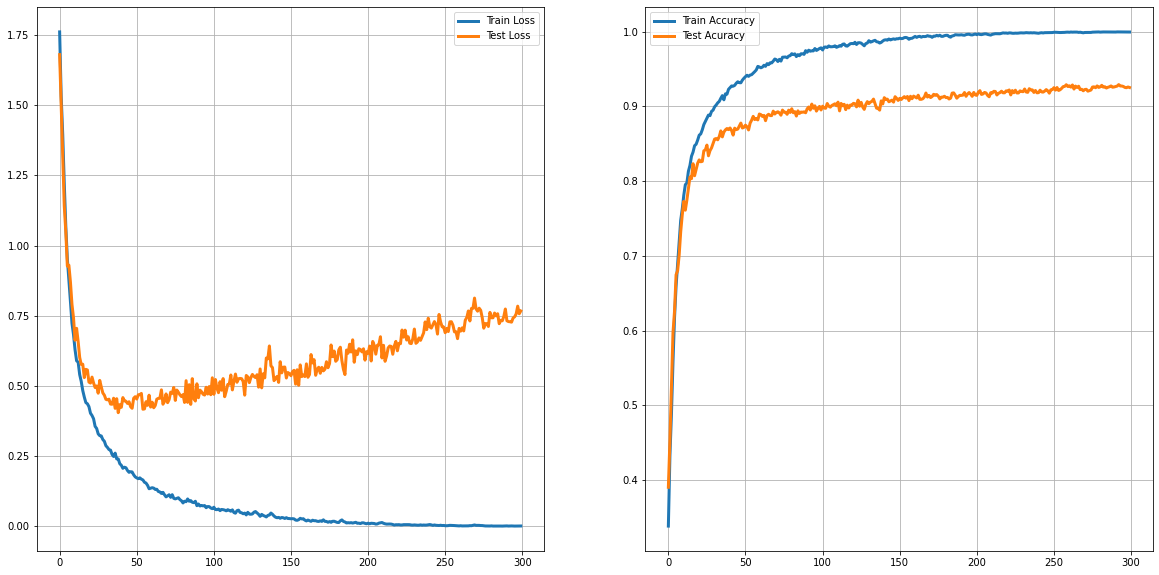

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Loss')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Loss')
ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy')
ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()
f.savefig("./trainandtest.png")